<a href="https://colab.research.google.com/github/awagler2/NODE/blob/main/CIPanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


In [2]:
# Sample dataset
data = {
    "CIP Code": ["14.0901", "14.0702", "09.0102", "14.1001", "09.0701"],
    "Description": [
        "Computer Engineering, General",
        "Chemical Engineering",
        "Mass Communication/Media Studies",
        "Electrical and Electronics Engineering",
        "Radio and Television Broadcasting"
    ]
}

df = pd.DataFrame(data)

#df=pd.read_csv('/content/NSF_CIP_codes.csv')


In [21]:
# External data (employment and salary)
external_data = {
    "CIP Code": ["14.0901", "14.0702", "09.0102", "14.1001", "09.0701"],
    "Median Salary": [85000, 75000, 45000, 80000, 50000],  # Median salary in USD
    "Employment Growth (%)": [12.0, 10.0, 8.0, 9.5, 7.0]  # Employment growth rate
}

external_df = pd.DataFrame(external_data)

external_df=pd.read_csv('/content/CIP2020_SOC2018_Crosswalk.csv', encoding='latin1')

external_df = external_df.rename(columns={'CIP2020Code': 'CIP Code'})

df=external_df[['CIP Code', 'CIP2020Title']]

In [22]:
# Merge external data with the main dataset
#print(df.columns.tolist())
#print(external_df.columns.tolist())
df_merged = pd.merge(df, external_df, on="CIP Code", how="left")


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Select columns to normalize
scaler = MinMaxScaler()
df_merged[['Median Salary', 'Employment Growth (%)']] = scaler.fit_transform(
    df_merged[['Median Salary', 'Employment Growth (%)']]
)


In [23]:
# Extract levels from CIP codes
df['CIP Code'] = df['CIP Code'].astype(str)
df['Level_1'] = df['CIP Code'].str[:2]  # Broad category (2-digit)
df['Level_2'] = df['CIP Code'].str[:5]  # Subfield (4-digit)
df['Level_3'] = df['CIP Code']          # Full code (6-digit)


<ipython-input-23-867297465d5a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CIP Code'] = df['CIP Code'].astype(str)
<ipython-input-23-867297465d5a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Level_1'] = df['CIP Code'].str[:2]  # Broad category (2-digit)


In [24]:
# One-hot encode the levels
# Use separate encoders for Level_1 and Level_2
encoder_level_1 = OneHotEncoder(handle_unknown='ignore') # Added handle_unknown for potential new categories
encoder_level_2 = OneHotEncoder(handle_unknown='ignore') # Added handle_unknown for potential new categories

level_1_encoded = encoder_level_1.fit_transform(df[['Level_1']])
level_2_encoded = encoder_level_2.fit_transform(df[['Level_2']])

# Convert encoded arrays to DataFrame for clarity
# Use the corresponding encoder to get the feature names
level_1_df = pd.DataFrame(level_1_encoded.toarray(), columns=encoder_level_1.get_feature_names_out(['Level_1']))
level_2_df = pd.DataFrame(level_2_encoded.toarray(), columns=encoder_level_2.get_feature_names_out(['Level_2']))

# Merge encoded features back into the original DataFrame
df_encoded = pd.concat([df, level_1_df, level_2_df], axis=1)


In [27]:
# Use TF-IDF to encode text descriptions
print(df.columns.tolist())
tfidf = TfidfVectorizer(max_features=10)  # Limit features for simplicity
text_features = tfidf.fit_transform(df['CIP2020Title']).toarray()

# Convert to DataFrame
text_features_df = pd.DataFrame(text_features, columns=tfidf.get_feature_names_out())

# Merge text features into the dataset
df_final = pd.concat([df_encoded, text_features_df], axis=1)


['CIP Code', 'CIP2020Title', 'Level_1', 'Level_2', 'Level_3']


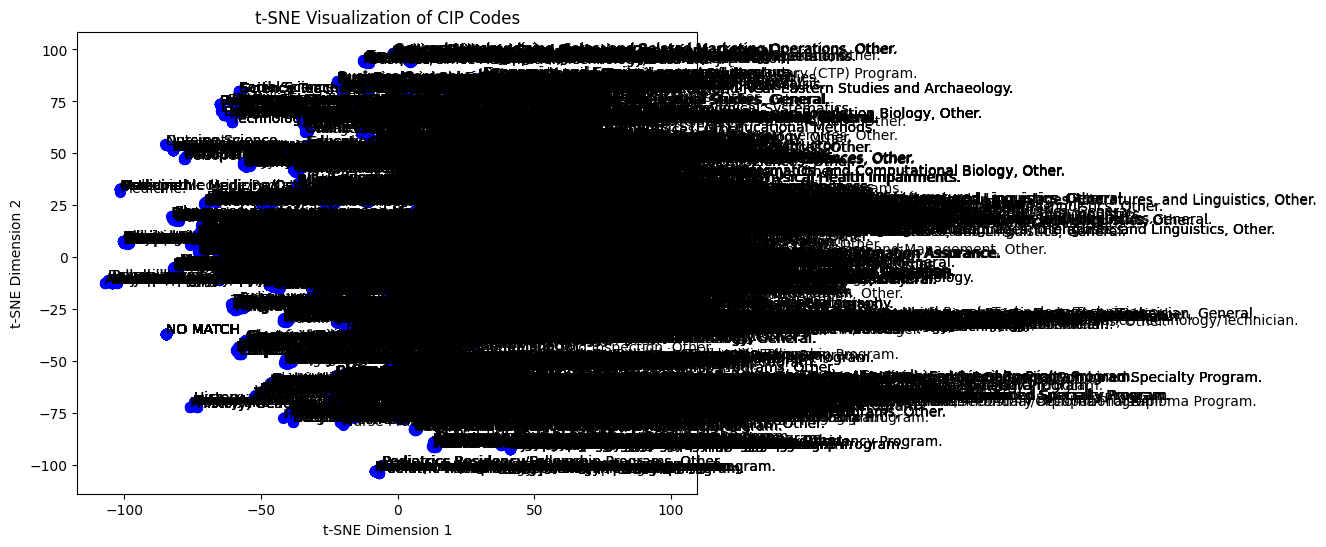

In [37]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Drop non-numeric and original columns not needed for t-SNE
features = df_final.drop(columns=['CIP Code', 'CIP2020Title', 'Level_1', 'Level_2', 'Level_3'])

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Add t-SNE results to the DataFrame
df_final['t-SNE_1'] = tsne_results[:, 0]
df_final['t-SNE_2'] = tsne_results[:, 1]

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(df_final['t-SNE_1'], df_final['t-SNE_2'], c='blue', s=50)
for i, label in enumerate(df['CIP2020Title']):
    plt.annotate(label, (df_final['t-SNE_1'][i], df_final['t-SNE_2'][i]))
plt.title("t-SNE Visualization of CIP Codes")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


In [38]:
# Include the new features in the t-SNE input
#features_with_external = df_final.drop(columns=[
#    'CIP Code', 'CIP2020Title', 'Level_1', 'Level_2', 'Level_3', 't-SNE_1', 't-SNE_2'
#])
df_final.to_csv('df_final.csv', index=False)
# Run t-SNE again
tsne = TSNE(n_components=2, random_state=42)
tsne_results_with_external = tsne.fit_transform(features_with_external)

# Add updated t-SNE results to the DataFrame
#df_final['t-SNE_1'] = tsne_results_with_external[:, 0]
#df_final['t-SNE_2'] = tsne_results_with_external[:, 1]
# Run t-SNE again
tsne = TSNE(n_components=2, random_state=42)
tsne_results_with_external = tsne.fit_transform(features_with_external)

# Add updated t-SNE results to the DataFrame
#df_merged['t-SNE_1'] = tsne_results_with_external[:, 0]
#df_merged['t-SNE_2'] = tsne_results_with_external[:, 1]


['CIP Code', 'CIP2020Title', 'Level_1', 'Level_2', 'Level_3', 'Level_1_1.', 'Level_1_10', 'Level_1_11', 'Level_1_12', 'Level_1_13', 'Level_1_14', 'Level_1_15', 'Level_1_16', 'Level_1_19', 'Level_1_22', 'Level_1_23', 'Level_1_24', 'Level_1_25', 'Level_1_26', 'Level_1_27', 'Level_1_28', 'Level_1_29', 'Level_1_3.', 'Level_1_30', 'Level_1_31', 'Level_1_32', 'Level_1_33', 'Level_1_34', 'Level_1_35', 'Level_1_36', 'Level_1_37', 'Level_1_38', 'Level_1_39', 'Level_1_4.', 'Level_1_40', 'Level_1_41', 'Level_1_42', 'Level_1_43', 'Level_1_44', 'Level_1_45', 'Level_1_46', 'Level_1_47', 'Level_1_48', 'Level_1_49', 'Level_1_5.', 'Level_1_50', 'Level_1_51', 'Level_1_52', 'Level_1_53', 'Level_1_54', 'Level_1_60', 'Level_1_61', 'Level_1_9.', 'Level_1_99', 'Level_2_1.0', 'Level_2_1.010', 'Level_2_1.019', 'Level_2_1.020', 'Level_2_1.029', 'Level_2_1.030', 'Level_2_1.031', 'Level_2_1.039', 'Level_2_1.040', 'Level_2_1.050', 'Level_2_1.059', 'Level_2_1.060', 'Level_2_1.061', 'Level_2_1.069', 'Level_2_1.070',

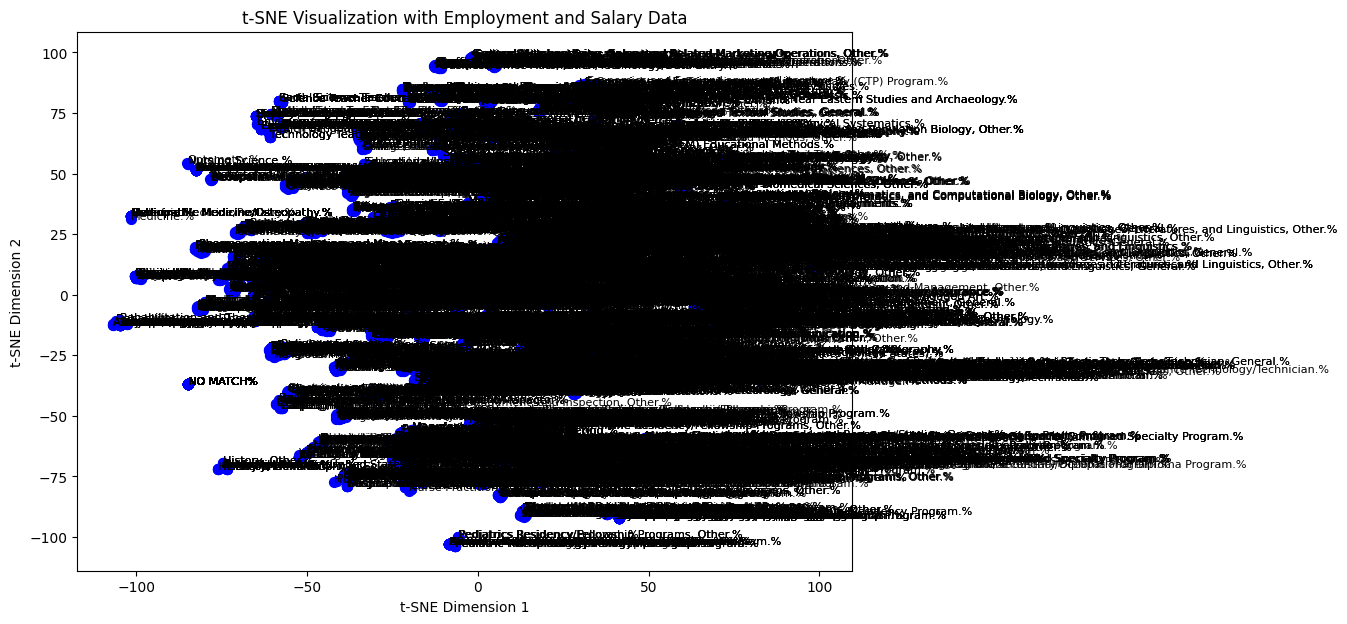

In [43]:
# Plot the results
import matplotlib.pyplot as plt
print(df_final.columns.tolist())
# Plot the results
plt.figure(figsize=(10, 7))
plt.scatter(df_final['t-SNE_1'], df_final['t-SNE_2'], c='blue', s=50)

# Annotate with employment and salary info
for i, row in df_final.iterrows():
    label = f"{row['CIP2020Title']}%"
    plt.annotate(label, (row['t-SNE_1'], row['t-SNE_2']), fontsize=8)

plt.title("t-SNE Visualization with Employment and Salary Data")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()
